### 1. Importa√ß√£o de bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import select_order
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import jarque_bera

import warnings
warnings.filterwarnings('ignore')

### 2. Leitura e prepara√ß√£o de dados:

In [2]:
df = pd.read_excel("base_geral.xlsx")

df['ano'] = df['sem_ano'].map(lambda x: x[:4])

df['ano'] = df['ano'].astype(int)

df = df.set_index("sem_ano")

#df = df[df['ano'] >= 2024]

df = df.drop(columns= ["Price_sem_brent", "Price_sem_euro", "ano"], axis = 1)

df = df.rename(columns= {'Price_sem_brent_ajus': 'Price_sem_brent'})

display(df)

Price_sem_gasoline  Price_sem_dolar  Price_sem_brent
sem_ano                                                      
2020-01            4.258600         4.037667       272.239675
2020-02            4.248167         4.076720       271.485092
2020-03            4.272609         4.160520       268.070625
2020-04            4.241917         4.187600       264.430190
2020-05            4.207542         4.231680       249.745290
...                     ...              ...              ...
2024-48            5.862632         6.089400       433.078128
2024-49            5.861579         6.041900       450.061131
2024-50            5.853684         6.085300       443.861782
2024-51            5.841053         6.196400       459.586988
2024-52            5.846842         6.179800       472.816498

[226 rows x 3 columns]

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 226 entries, 2020-01 to 2024-52
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price_sem_gasoline  226 non-null    float64
 1   Price_sem_dolar     226 non-null    float64
 2   Price_sem_brent     226 non-null    float64
dtypes: float64(3)
memory usage: 7.1+ KB
None


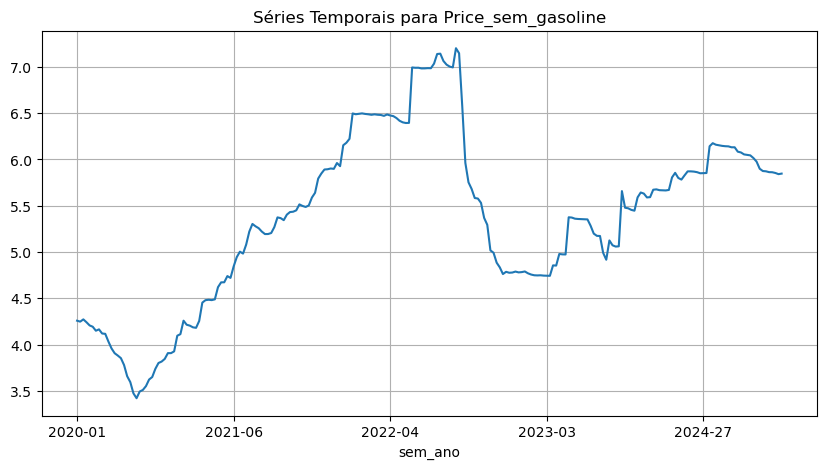

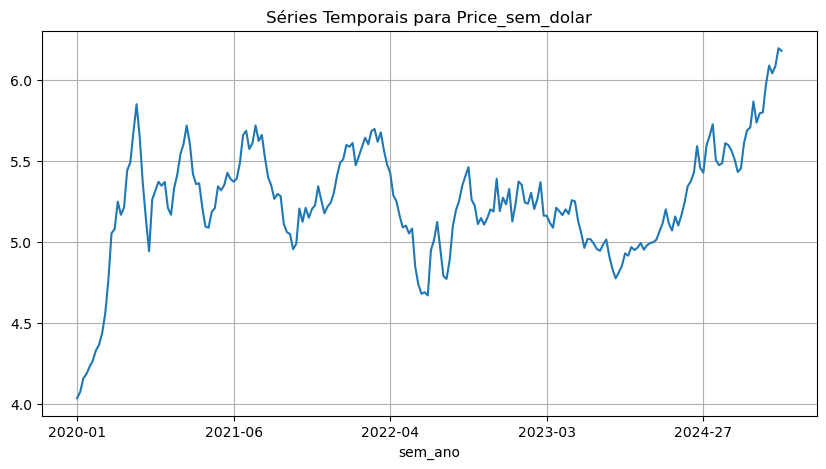

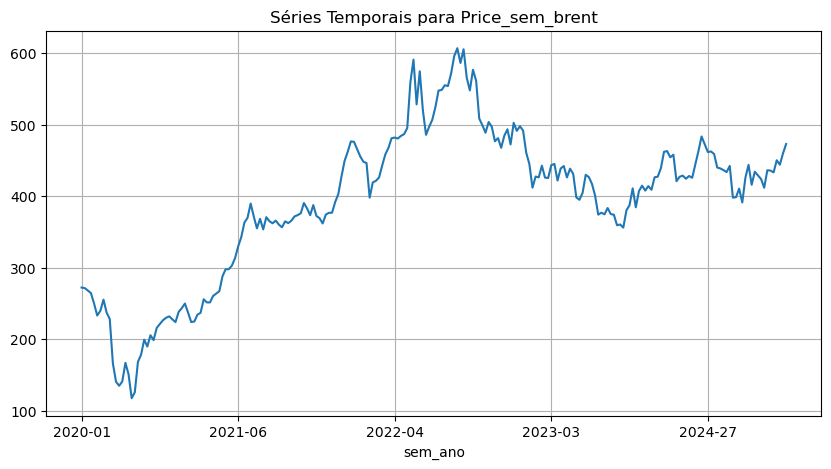

In [4]:
for col in df.columns:
    df[col].plot(title=f'S√©ries Temporais para {col}', figsize=(10, 5))
    plt.grid(True)
    plt.show()

### 4. Visualiza√ß√£o e Correla√ß√£o

In [5]:
df.describe()

Price_sem_gasoline  Price_sem_dolar  Price_sem_brent
count          226.000000       226.000000       226.000000
mean             5.365312         5.249872       392.568999
std              0.913969         0.353931       105.723753
min              3.421208         4.037667       117.613640
25%              4.758158         5.081370       359.489954
50%              5.433433         5.243940       416.417078
75%              5.952698         5.471765       460.360396
max              7.200833         6.196400       606.565823

<Axes: >

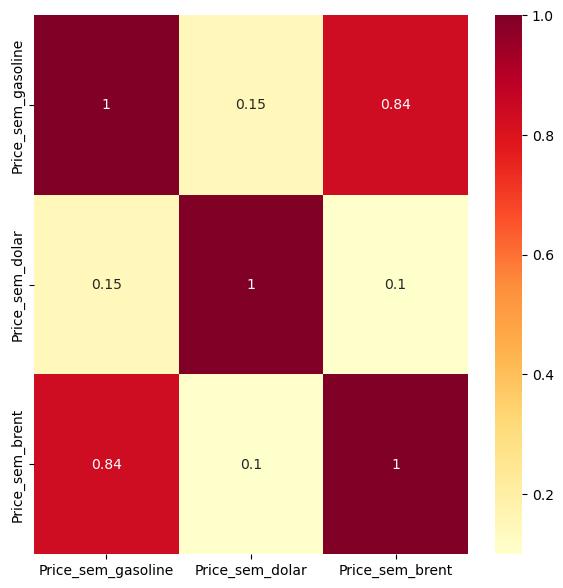

In [6]:
plt.figure(figsize=(7,7))
correlacao = df.corr()
sns.heatmap(correlacao, annot = True,cmap = "YlOrRd")

### 5. Estacionariedade (ADF Test)

In [7]:
def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Test para {name}')
    print(f'Estat√≠stica: {result[0]}')
    print(f'Valor-p: {result[1]}')
    print(f'Valores cr√≠ticos: {result[4]}')
    if result[1] > 0.05:
        print('N√£o rejeita H‚ÇÄ ‚Üí s√©rie tem raiz unit√°ria ‚Üí n√£o estacion√°ria')
    else:
        print('Rejeita H‚ÇÄ ‚Üí s√©rie estacion√°ria')
    print('--------------------------------------------------------------------------------------------------')

for col in df.columns:
    adf_test(df[col], col)

ADF Test para Price_sem_gasoline
Estat√≠stica: -1.4201500153036337
Valor-p: 0.5725787384207544
Valores cr√≠ticos: {'1%': -3.459884913337196, '5%': -2.8745310704320794, '10%': -2.573693840082908}
N√£o rejeita H‚ÇÄ ‚Üí s√©rie tem raiz unit√°ria ‚Üí n√£o estacion√°ria
--------------------------------------------------------------------------------------------------
ADF Test para Price_sem_dolar
Estat√≠stica: -3.1261949682012458
Valor-p: 0.02467440456778593
Valores cr√≠ticos: {'1%': -3.459884913337196, '5%': -2.8745310704320794, '10%': -2.573693840082908}
Rejeita H‚ÇÄ ‚Üí s√©rie estacion√°ria
--------------------------------------------------------------------------------------------------
ADF Test para Price_sem_brent
Estat√≠stica: -1.44822514304539
Valor-p: 0.558950696978437
Valores cr√≠ticos: {'1%': -3.4602906385073884, '5%': -2.874708679520702, '10%': -2.573788599127782}
N√£o rejeita H‚ÇÄ ‚Üí s√©rie tem raiz unit√°ria ‚Üí n√£o estacion√°ria
---------------------------------------------

### 6. Cointegra√ß√£o (Johansen)

In [8]:
cj = coint_johansen(df, det_order=0, k_ar_diff=1)
print('Eigenvalues:', cj.eig)
print('Trace statistic:', cj.lr1)
print('Critical values (90%, 95%, 99%):\n', cj.cvt)

print("-------------------------------------------------------------------------------------------------------")

vetor_cointegracao = []

for i, j in zip(cj.lr1, cj.cvt[:, 1]): #para 95%
    if i > j:
        print(round(i,6), "maior que", round(j, 6), "Rejeita a hip√≥tese nula: h√° cointegra√ß√£o entre as s√©ries")
        vetor_cointegracao.append(1)
    else:
        print(round(i,6), "menor ou igual que", round(j, 6), "N√£o Rejeita a hip√≥tese nula: n√£o h√° cointegra√ß√£o entre as s√©ries")
        vetor_cointegracao.append(0)
print("-------------------------------------------------------------------------------------------------------")

if sum(vetor_cointegracao) > 0:
    print(f"Modelo apropriado: VECM ‚Äì Vector Error Correction Model com r = {sum(vetor_cointegracao)} vetores de cointegra√ß√£o")
else:
    print("Modelo apropriado: VAR - Vector Autoregression")

Eigenvalues: [0.05513894 0.04805489 0.00977058]
Trace statistic: [25.93559934 13.23090334  2.19937292]
Critical values (90%, 95%, 99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
-------------------------------------------------------------------------------------------------------
25.935599 menor ou igual que 29.7961 N√£o Rejeita a hip√≥tese nula: n√£o h√° cointegra√ß√£o entre as s√©ries
13.230903 menor ou igual que 15.4943 N√£o Rejeita a hip√≥tese nula: n√£o h√° cointegra√ß√£o entre as s√©ries
2.199373 menor ou igual que 3.8415 N√£o Rejeita a hip√≥tese nula: n√£o h√° cointegra√ß√£o entre as s√©ries
-------------------------------------------------------------------------------------------------------
Modelo apropriado: VAR - Vector Autoregression


### 7. Diferencia√ß√£o das s√©ries

ADF Test para Price_sem_gasoline (1¬™ diferen√ßa)
Estat√≠stica: -11.527134900366203
Valor-p: 3.91134368417349e-21
Valores cr√≠ticos: {'1%': -3.459884913337196, '5%': -2.8745310704320794, '10%': -2.573693840082908}
Rejeita H‚ÇÄ ‚Üí s√©rie estacion√°ria
--------------------------------------------------------------------------------------------------
ADF Test para Price_sem_dolar (1¬™ diferen√ßa)
Estat√≠stica: -8.099335544221098
Valor-p: 1.312691830870836e-12
Valores cr√≠ticos: {'1%': -3.4602906385073884, '5%': -2.874708679520702, '10%': -2.573788599127782}
Rejeita H‚ÇÄ ‚Üí s√©rie estacion√°ria
--------------------------------------------------------------------------------------------------
ADF Test para Price_sem_brent (1¬™ diferen√ßa)
Estat√≠stica: -8.124816996805727
Valor-p: 1.1305938053048907e-12
Valores cr√≠ticos: {'1%': -3.4602906385073884, '5%': -2.874708679520702, '10%': -2.573788599127782}
Rejeita H‚ÇÄ ‚Üí s√©rie estacion√°ria
---------------------------------------------------

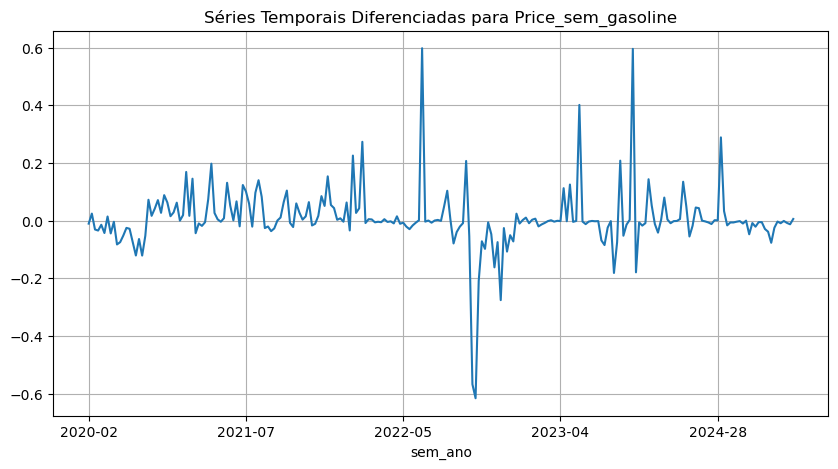

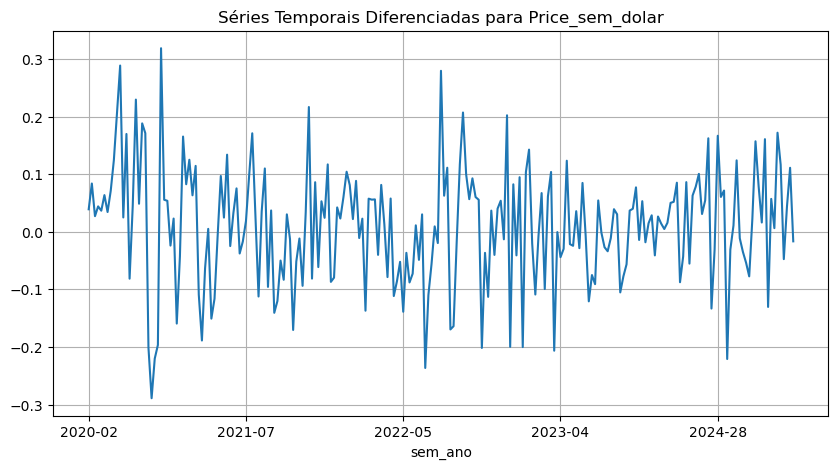

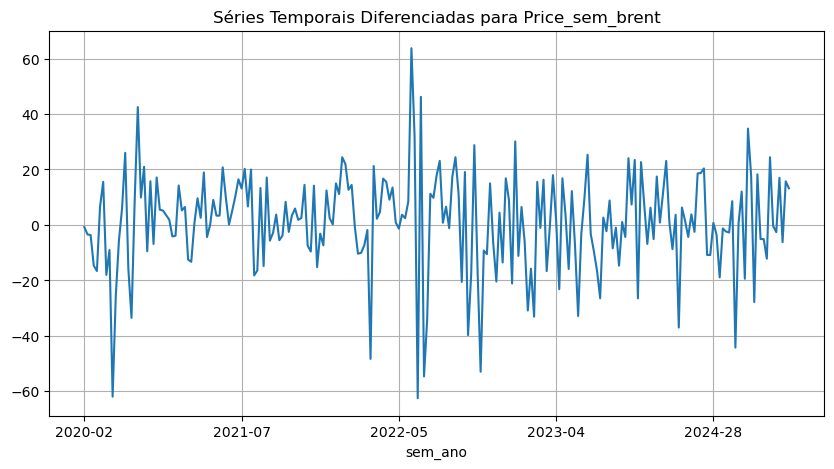

Price_sem_gasoline  Price_sem_dolar  Price_sem_brent
sem_ano                                                      
2020-02           -0.010433         0.039053        -0.754583
2020-03            0.024442         0.083800        -3.414467
2020-04           -0.030692         0.027080        -3.640435
2020-05           -0.034375         0.044080       -14.684899
2020-06           -0.014333         0.036620       -16.619281
...                     ...              ...              ...
2024-48           -0.008947         0.116400        -2.592492
2024-49           -0.001053        -0.047500        16.983003
2024-50           -0.007895         0.043400        -6.199349
2024-51           -0.012632         0.111100        15.725206
2024-52            0.005789        -0.016600        13.229510

[225 rows x 3 columns]

In [9]:
df_diff = df.diff().dropna()

for col in df_diff.columns:
    adf_test(df_diff[col], f"{col} (1¬™ diferen√ßa)")

for col in df_diff.columns:
    df_diff[col].plot(title=f'S√©ries Temporais Diferenciadas para {col}', figsize=(10, 5))
    plt.grid(True)
    plt.show()

display(df_diff)

### 8. Sele√ß√£o de defasagem (Lag)


In [10]:
model = VAR(df_diff)
lag_order = model.select_order(maxlags=10)
print(lag_order.summary())

best_lag = lag_order.aic + 1

print(f"Modelo com {lag_order.aic + 1} defasagens como o ideal (AIC)")

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -3.237     -3.190*     0.03927     -3.218*
1      -3.281*      -3.093    0.03758*      -3.205
2       -3.243      -2.914     0.03905      -3.110
3       -3.246      -2.776     0.03893      -3.056
4       -3.238      -2.626     0.03927      -2.991
5       -3.170      -2.417     0.04205      -2.866
6       -3.125      -2.232     0.04398      -2.764
7       -3.071      -2.036     0.04649      -2.653
8       -3.020      -1.845     0.04894      -2.545
9       -2.997      -1.680     0.05016      -2.465
10      -2.959      -1.501     0.05221      -2.370
--------------------------------------------------
Modelo com 2 defasagens como o ideal (AIC)


### 9. juste do modelo VAR

In [11]:
var_model = model.fit(best_lag)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 25, Jun, 2025
Time:                     15:29:31
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -2.92853
Nobs:                     223.000    HQIC:                  -3.11985
Log likelihood:          -565.964    FPE:                  0.0388006
AIC:                     -3.24938    Det(Omega_mle):       0.0353647
--------------------------------------------------------------------
Results for equation Price_sem_gasoline
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.004125         0.007009            0.589           0.556
L1.Price_sem_gasoline         0.211815         0.067163            3.154           0.002
L1.Price_sem_do

### 10. ‚ö†Ô∏è Problema de Normalidade nos Res√≠duos

In [12]:
jb_test = var_model.test_normality()
print(jb_test.summary())
pvalor = jb_test.pvalue
if pvalor > 0.05:
    normalidade = 'H‚ÇÄ (nula): os res√≠duos do modelo seguem uma distribui√ß√£o normal'
else:
    normalidade = 'H‚ÇÅ (alternativa): os res√≠duos n√£o seguem distribui√ß√£o normal'

print(normalidade)

print("Est√°vel?" , var_model.is_stable())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         1812.          12.59   0.000  6
----------------------------------------
H‚ÇÅ (alternativa): os res√≠duos n√£o seguem distribui√ß√£o normal
Est√°vel? True


In [14]:
# dataframe com os dados dos res√≠duos
residuals = pd.DataFrame(var_model.resid, columns=['Price_sem_gasoline','Price_sem_dolar','Price_sem_brent'])
residuals

Price_sem_gasoline  Price_sem_dolar  Price_sem_brent
sem_ano                                                      
2020-04           -0.034624         0.006127        -5.255982
2020-05           -0.020083         0.028873       -14.007951
2020-06            0.009944         0.020134       -17.789499
2020-07           -0.009065         0.048297         5.726519
2020-08            0.028839         0.013528        14.862789
...                     ...              ...              ...
2024-48           -0.037811         0.082173        -5.939945
2024-49            0.009898        -0.080452        17.827872
2024-50           -0.017295         0.034953        -4.149666
2024-51           -0.028692         0.099395        13.161669
2024-52           -0.006622        -0.044229        11.958985

[223 rows x 3 columns]

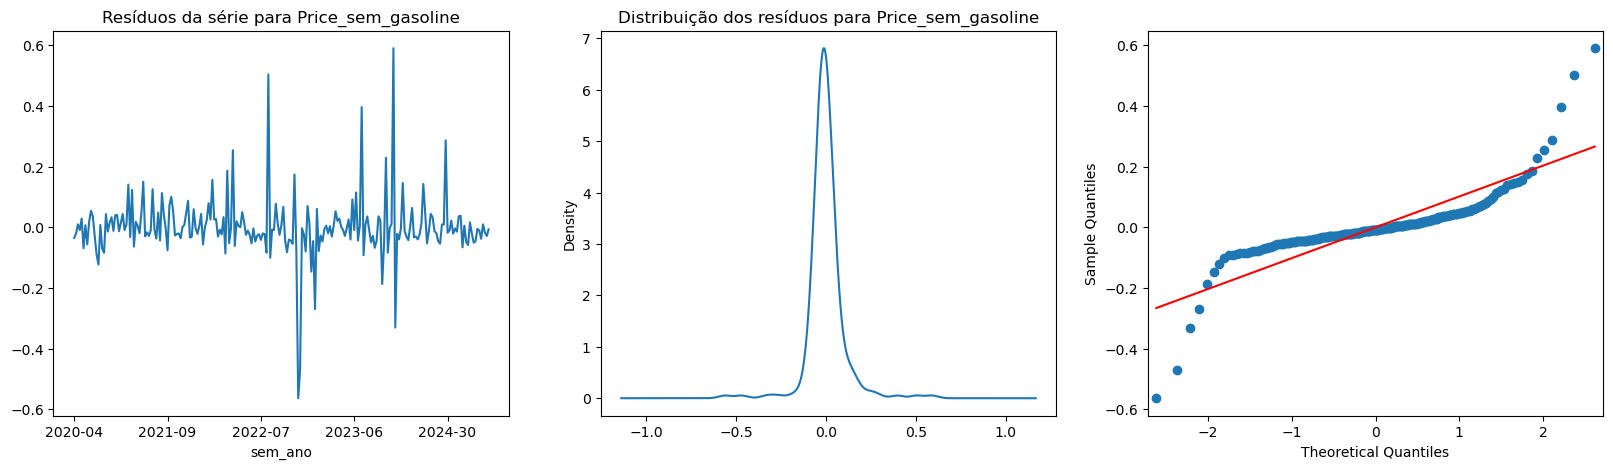

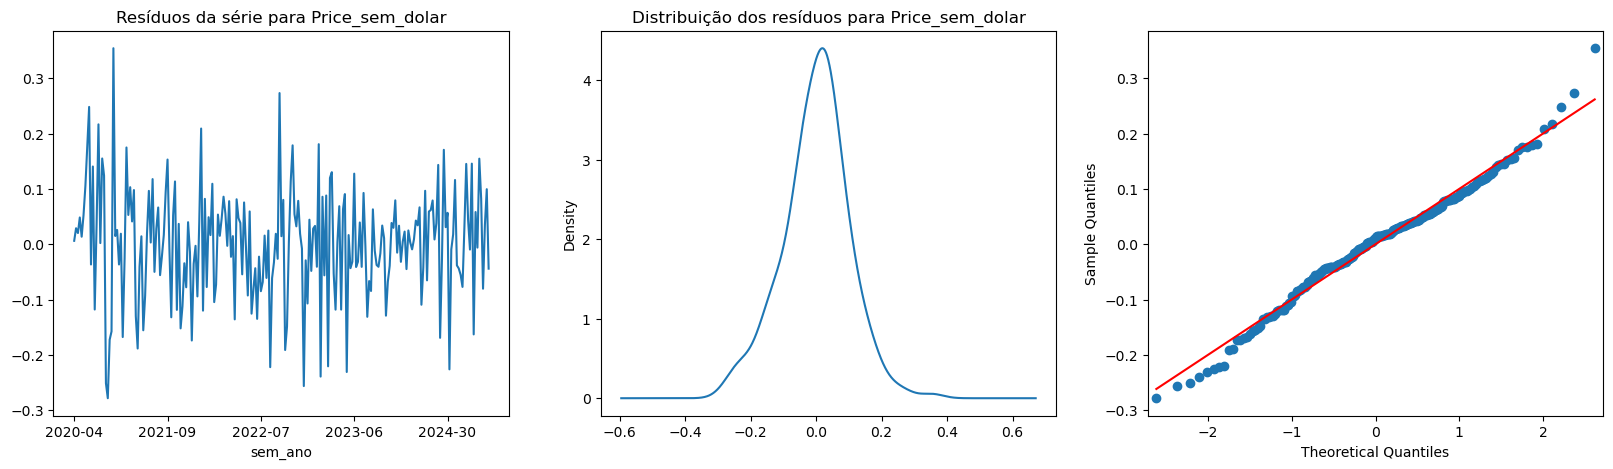

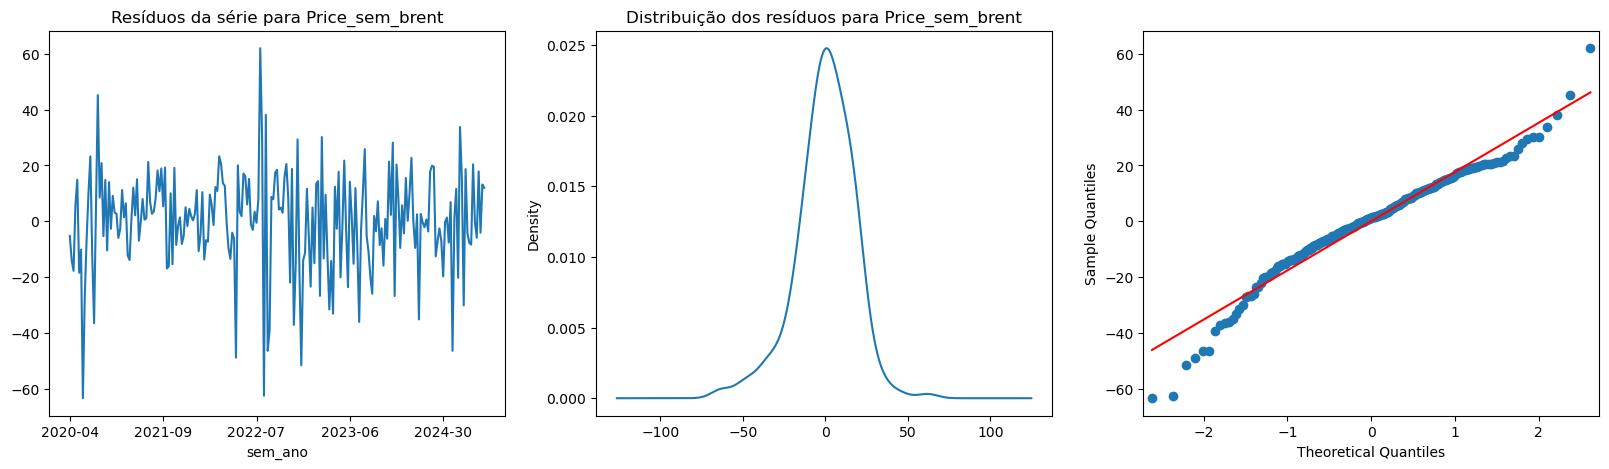

In [17]:
for col in residuals.columns:
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    residuals[col].plot(title=f"Res√≠duos da s√©rie para {col}", ax=ax[0])
    residuals[col].plot(kind='kde', title=f'Distribui√ß√£o dos res√≠duos para {col}', ax=ax[1])
    qqplot(residuals[col],line='s', ax=ax[2])
    

In [18]:
for col in residuals.columns:    
    test = jarque_bera(residuals[col])
    print(f'Para a s√©rie {col}')
    print('Estat√≠stica Jarque-Bera :', test[0])
    print('P-valor :', test[1])
    print('Assimetria :', test[2])
    print('Curtose :',test[3])    
    if test[1] > 0.05:
        normalidade = 'H‚ÇÄ (nula): os res√≠duos do modelo seguem uma distribui√ß√£o normal'
    else:
        normalidade = 'H‚ÇÅ (alternativa): os res√≠duos n√£o seguem distribui√ß√£o normal'
    print(normalidade)
    print(50*"-")

Para a s√©rie Price_sem_gasoline
Estat√≠stica Jarque-Bera : 1763.5640672997533
P-valor : 0.0
Assimetria : 0.5371736769323737
Curtose : 16.73486056979602
H‚ÇÅ (alternativa): os res√≠duos n√£o seguem distribui√ß√£o normal
--------------------------------------------------
Para a s√©rie Price_sem_dolar
Estat√≠stica Jarque-Bera : 4.5312664065246455
P-valor : 0.1037643098349437
Assimetria : -0.09609696496347357
Curtose : 3.671365340525439
H‚ÇÄ (nula): os res√≠duos do modelo seguem uma distribui√ß√£o normal
--------------------------------------------------
Para a s√©rie Price_sem_brent
Estat√≠stica Jarque-Bera : 39.435096410217405
P-valor : 2.733868480090793e-09
Assimetria : -0.5765562526232529
Curtose : 4.7071811523004135
H‚ÇÅ (alternativa): os res√≠duos n√£o seguem distribui√ß√£o normal
--------------------------------------------------


### 11. Autocorrela√ß√£o dos res√≠duos: Ljung-Box e Portmanteau ‚Üí sem evid√™ncia de autocorrela√ß√£o

In [19]:
resid = var_model.resid

for col in resid.columns:
    resultado = acorr_ljungbox(resid[col], lags=[10], return_df=True)
    pvalor = resultado['lb_pvalue'].iloc[0]
    if pvalor > 0.05:
        autocorrelacao = 'H‚ÇÄ (nula): os res√≠duos s√£o n√£o autocorrelacionados (comportamento de ru√≠do branco)'
    else:
        autocorrelacao = 'H‚ÇÅ (alternativa): os res√≠duos s√£o autocorrelacionados'

    print(f"Ljung-Box para {col}: p-valor = {pvalor:.4f} ‚áí {autocorrelacao}")

Ljung-Box para Price_sem_gasoline: p-valor = 0.8751 ‚áí H‚ÇÄ (nula): os res√≠duos s√£o n√£o autocorrelacionados (comportamento de ru√≠do branco)
Ljung-Box para Price_sem_dolar: p-valor = 0.4405 ‚áí H‚ÇÄ (nula): os res√≠duos s√£o n√£o autocorrelacionados (comportamento de ru√≠do branco)
Ljung-Box para Price_sem_brent: p-valor = 0.2992 ‚áí H‚ÇÄ (nula): os res√≠duos s√£o n√£o autocorrelacionados (comportamento de ru√≠do branco)


In [20]:
white_test = var_model.test_whiteness(nlags=10, adjusted=True)
print(white_test.summary())
print(50*"*")
pvalor = white_test.pvalue

if pvalor > 0.05:
    autocorrelacao = 'H‚ÇÄ (nula): os res√≠duos s√£o n√£o autocorrelacionados (comportamento de ru√≠do branco)'
else:
    autocorrelacao = 'H‚ÇÅ (alternativa): os res√≠duos s√£o autocorrelacionados'

print(f"Adjusted Portmanteau: p-valor = {pvalor:.4f} ‚áí {autocorrelacao}")

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 10 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         77.94          92.81   0.296 72
----------------------------------------
**************************************************
Adjusted Portmanteau: p-valor = 0.2956 ‚áí H‚ÇÄ (nula): os res√≠duos s√£o n√£o autocorrelacionados (comportamento de ru√≠do branco)


### 12. Testes de Causalidade de Grange


Resumo dos Resultados por Par de Vari√°veis

‚úÖ 1. Price_sem_brent ‚Üí Price_sem_gasoline

Todos os lags (1 a 4) mostram p-valores < 0.05, ou seja:

H√° forte evid√™ncia de causalidade de Granger.

Interpreta√ß√£o: mudan√ßas nos pre√ßos do Brent ajudam a prever mudan√ßas no pre√ßo da gasolina no curto prazo.

‚ö†Ô∏è 2. Price_sem_dolar ‚Üí Price_sem_gasoline

Apenas no lag 3 houve rejei√ß√£o da hip√≥tese nula (p = 0.0449).

Nos demais lags, n√£o h√° evid√™ncia.

Interpreta√ß√£o: existe evid√™ncia pontual e fraca de que o d√≥lar causa varia√ß√µes na gasolina, mas n√£o √© consistente ao longo de m√∫ltiplos defasagens. Pode indicar uma rela√ß√£o espor√°dica ou transit√≥ria.

‚ùå 3. Price_sem_gasoline ‚Üí Price_sem_dolar
Todos os p-valores s√£o acima de 0.3.

Sem evid√™ncia de causalidade.

‚ùå 4. Price_sem_brent ‚Üí Price_sem_dolar
Todos os p-valores bem acima de 0.4‚Äì0.9.

Sem evid√™ncia de causalidade.

‚ùå 5. Price_sem_gasoline ‚Üí Price_sem_brent
Nenhum p-valor significativo.

Gasolina n√£o afeta Brent, o que √© coerente, j√° que Brent √© refer√™ncia global.

‚ùå 6. Price_sem_dolar ‚Üí Price_sem_brent
Todos os p-valores elevados.

Sem causalidade detectada.

In [21]:
for col in df_diff.columns:
    for other_col in df.columns:
        if col != other_col:
            print(f"\nTeste Granger: {other_col} causa {col}?")
            resultado = grangercausalitytests(df_diff[[col, other_col]].dropna(), maxlag=4, verbose=False)
            for lag in range(1, 5):
                pvalor = resultado[lag][0]['ssr_chi2test'][1]  # √≠ndice [1] √© o p-valor
                if pvalor < 0.05:
                    causa_granger = "rejeita H‚ÇÄ ‚áí a vari√°vel causa a outra no sentido de Granger"
                else:
                    causa_granger = "n√£o rejeita H‚ÇÄ ‚áí sem evid√™ncia de causalidade de Granger"
                print(f"Lag {lag} ‚Üí p-valor: {pvalor:.4f} - {causa_granger}")


Teste Granger: Price_sem_dolar causa Price_sem_gasoline?
Lag 1 ‚Üí p-valor: 0.7233 - n√£o rejeita H‚ÇÄ ‚áí sem evid√™ncia de causalidade de Granger
Lag 2 ‚Üí p-valor: 0.6044 - n√£o rejeita H‚ÇÄ ‚áí sem evid√™ncia de causalidade de Granger
Lag 3 ‚Üí p-valor: 0.0449 - rejeita H‚ÇÄ ‚áí a vari√°vel causa a outra no sentido de Granger
Lag 4 ‚Üí p-valor: 0.0936 - n√£o rejeita H‚ÇÄ ‚áí sem evid√™ncia de causalidade de Granger

Teste Granger: Price_sem_brent causa Price_sem_gasoline?
Lag 1 ‚Üí p-valor: 0.0070 - rejeita H‚ÇÄ ‚áí a vari√°vel causa a outra no sentido de Granger
Lag 2 ‚Üí p-valor: 0.0017 - rejeita H‚ÇÄ ‚áí a vari√°vel causa a outra no sentido de Granger
Lag 3 ‚Üí p-valor: 0.0027 - rejeita H‚ÇÄ ‚áí a vari√°vel causa a outra no sentido de Granger
Lag 4 ‚Üí p-valor: 0.0056 - rejeita H‚ÇÄ ‚áí a vari√°vel causa a outra no sentido de Granger

Teste Granger: Price_sem_gasoline causa Price_sem_dolar?
Lag 1 ‚Üí p-valor: 0.5014 - n√£o rejeita H‚ÇÄ ‚áí sem evid√™ncia de causalidade de Grang

In [22]:
maxlag=10
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    
    milho = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in milho.columns:
        for r in milho.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            milho.loc[r, c] = min_p_value
    milho.columns = [var + '_x' for var in variables]
    milho.index = [var + '_y' for var in variables]
    return milho

grangers_causation_matrix(df_diff, variables = df_diff.columns)

Price_sem_gasoline_x  Price_sem_dolar_x  \
Price_sem_gasoline_y                1.0000             0.0449   
Price_sem_dolar_y                   0.2425             1.0000   
Price_sem_brent_y                   0.1529             0.1838   

                      Price_sem_brent_x  
Price_sem_gasoline_y             0.0017  
Price_sem_dolar_y                0.4651  
Price_sem_brent_y                1.0000

### 13. An√°lise da Fun√ß√£o Resposta ao Impulso (Impulse Response Function ‚Äì IRF)

 Conclus√µes Gerais

‚úÖ Price_sem_brent afeta Price_sem_gasoline: pequena mas significativa resposta positiva, alinhada com os testes de Granger.

‚ö†Ô∏è Price_sem_dolar tem impacto fraco ou insignificante sobre as demais vari√°veis.

‚ùå Gasolina n√£o causa d√≥lar ou Brent: confirmado visualmente.

üîÑ Autoregressividade presente em todas as vari√°veis, especialmente gasolina e d√≥lar.

üß† Implica√ß√µes para o Modelo

Brent deve ser mantido como vari√°vel explicativa central da gasolina.

A utiliza√ß√£o do d√≥lar como preditor pode ser secund√°ria ou descartada, a depender do objetivo.

A modelagem VAR est√° coerente com a estrutura de rela√ß√µes entre vari√°veis.

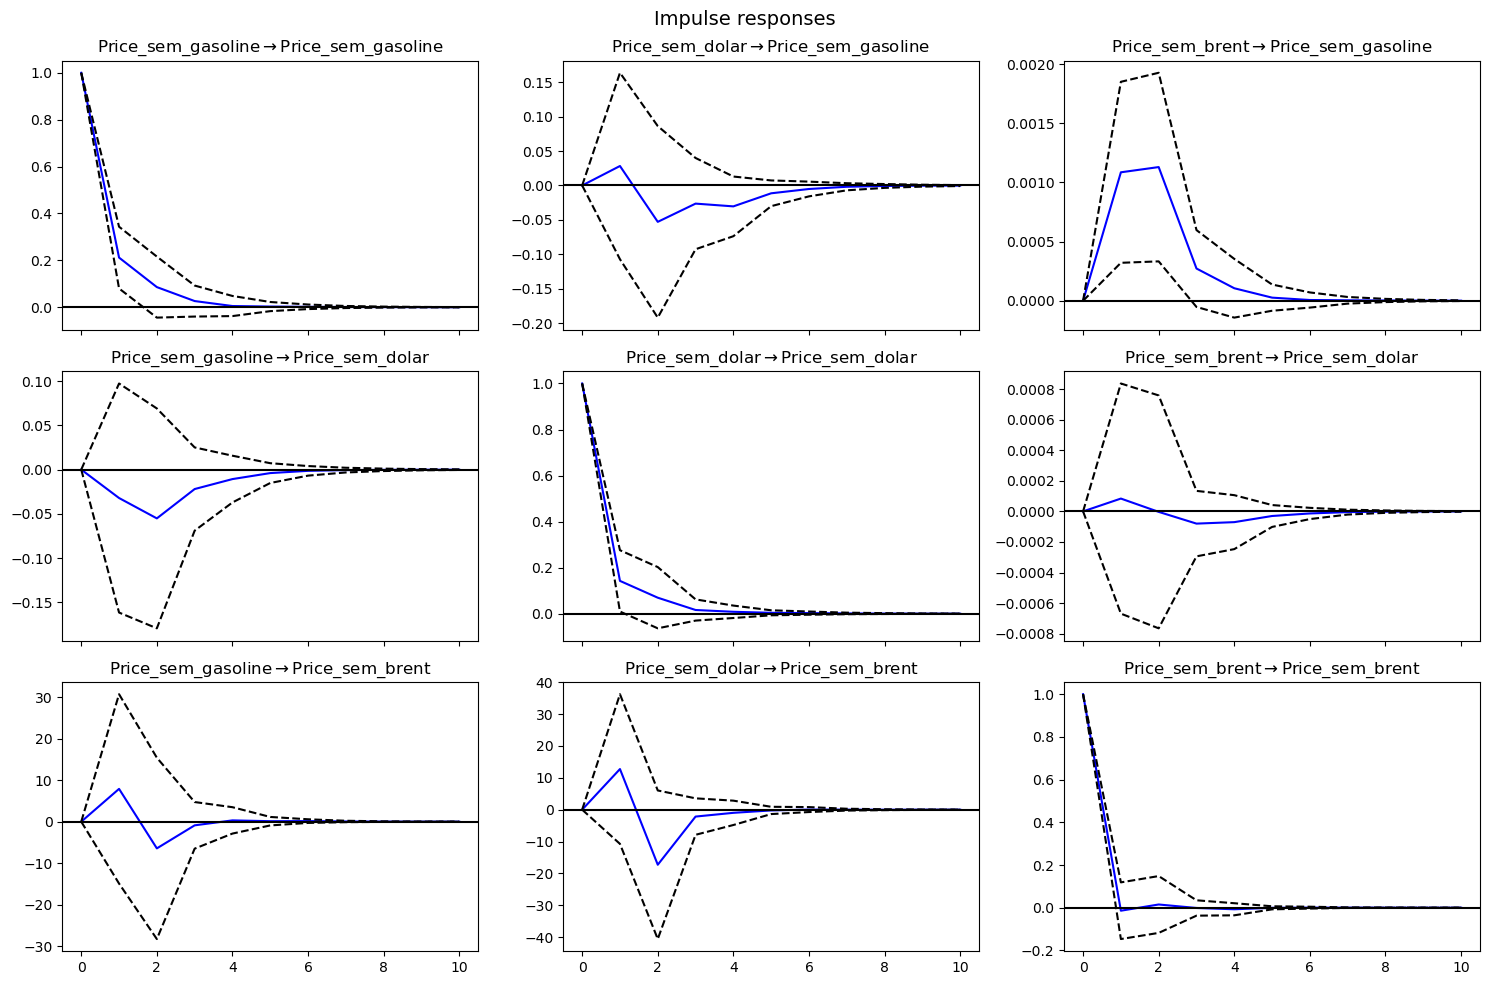

In [20]:
irf = var_model.irf(10)
irf.plot(orth=False, figsize=(15, 10))
plt.tight_layout()
plt.show()

FEVD for Price_sem_gasoline
     Price_sem_gasoline  Price_sem_dolar  Price_sem_brent
0              1.000000         0.000000         0.000000
1              0.966334         0.000926         0.032740
2              0.931873         0.002908         0.065219
3              0.929581         0.003445         0.066974
4              0.928600         0.004204         0.067196
5              0.928483         0.004311         0.067205
6              0.928462         0.004333         0.067204
7              0.928459         0.004336         0.067205
8              0.928459         0.004337         0.067205
9              0.928459         0.004337         0.067205

FEVD for Price_sem_dolar
     Price_sem_gasoline  Price_sem_dolar  Price_sem_brent
0              0.003513         0.996487         0.000000
1              0.005061         0.994726         0.000214
2              0.008536         0.991252         0.000212
3              0.009071         0.990525         0.000404
4              0.0

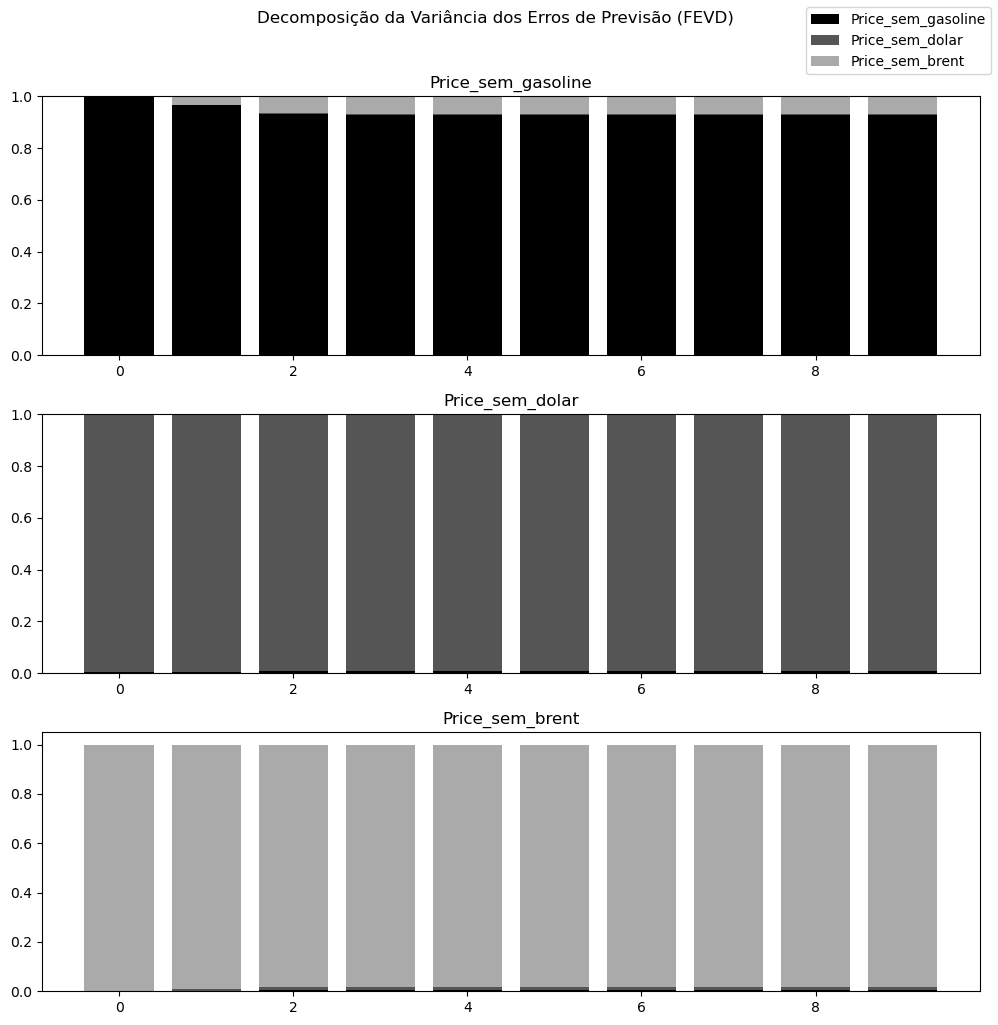

In [21]:
# Horizonte de previs√£o de 10 per√≠odos
fevd = var_model.fevd(10)

# Mostrar os resultados para y1 e y2
fevd.summary()

fevd.plot()
plt.suptitle("Decomposi√ß√£o da Vari√¢ncia dos Erros de Previs√£o (FEVD)", y=1.02)
plt.tight_layout()
plt.show()

### 14. Previs√£o Price_sem_gasoline

In [23]:
steps = 20
last_obs = df_diff.values[-var_model.k_ar:]
forecast_diff = var_model.forecast(y=last_obs, steps=steps)

# Cria DataFrame com as previs√µes das diferen√ßas
forecast_df = pd.DataFrame(forecast_diff, columns=df_diff.columns)

# √öltimo valor conhecido da s√©rie original (antes da diferen√ßa)
last_value = df['Price_sem_gasoline'].iloc[-1]

# Reconstruir a s√©rie no n√≠vel (somando cumulativamente as diferen√ßas)
forecast_level = forecast_df['Price_sem_gasoline'].cumsum() + last_value

display(forecast_level)

0     5.871494
1     5.893303
2     5.902758
3     5.911641
4     5.919223
5     5.926642
6     5.934019
7     5.941368
8     5.948699
9     5.956022
10    5.963339
11    5.970654
12    5.977968
13    5.985281
14    5.992594
15    5.999908
16    6.007221
17    6.014534
18    6.021847
19    6.029160
Name: Price_sem_gasoline, dtype: float64

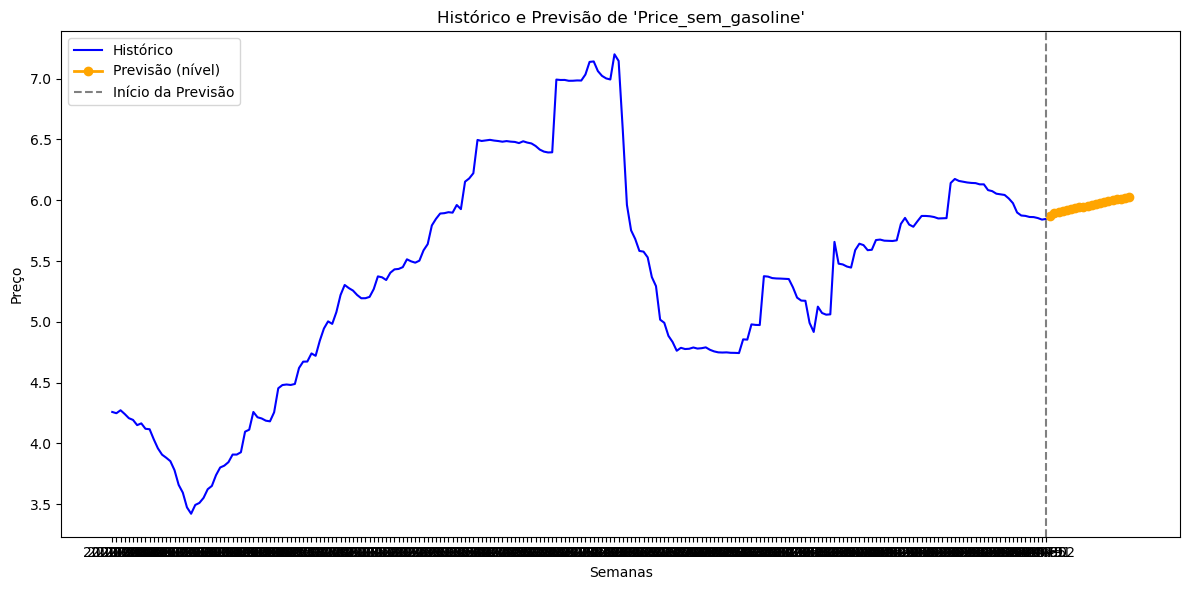

In [24]:
# Recriando o gr√°fico com base em uma s√©rie hist√≥rica j√° existente em df['Price_sem_gasoline']
# e incluindo a previs√£o (forecast_level) no mesmo gr√°fico com destaque

# √çndices para o eixo x
historical_index = df.index
forecast_index = np.arange(len(df), len(df) + len(forecast_level))

# Concatenando os dados previstos com os dados hist√≥ricos
plt.figure(figsize=(12, 6))
plt.plot(historical_index, df['Price_sem_gasoline'], label='Hist√≥rico', color='blue')
plt.plot(forecast_index, forecast_level, label='Previs√£o (n√≠vel)', color='orange', marker='o', linewidth=2)
plt.axvline(x=historical_index[-1], color='gray', linestyle='--', label='In√≠cio da Previs√£o')

# Estilizando o gr√°fico
plt.title("Hist√≥rico e Previs√£o de 'Price_sem_gasoline'")
plt.xlabel("Semanas")
plt.ylabel("Pre√ßo")
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()